# RFM Analysis

RFM analysis is a marketing technique used for analyzing customer value. It stands for Recency, Frequency, and Monetary value, representing a specific aspect of customer behavior. The idea is to segment customers based on these three factors to identify those who are more likely to respond to promotions and other marketing efforts. 

Recency (R): This measures how recently a customer made a purchase. The idea is that the more recent the purchase, the more likely the customer will be responsive to future offers. Customers who have purchased recently are often seen as more engaged and satisfied with the brand.

Frequency (F): This measures how often a customer makes a purchase within a given time frame. Frequent buyers are seen as more loyal and potentially more profitable, as they contribute regularly to the revenue stream.

Monetary Value (M): This reflects how much money a customer has spent over a certain period. Customers who spend more are often considered more valuable and potentially more profitable.

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [97]:
datamart = pd.read_csv('rfm_ml2.csv')

## Investigating Dataset

In [98]:
datamart.head()

,Recency,Frequency,MonetaryValue
0,2,12,196.89
1,3,182,4310.00
2,32,50,1257.51
3,23,77,1244.59
4,20,29,582.60


In [99]:
datamart.shape

(4338, 3)

In [100]:
datamart.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,93.059474,91.720609,2054.266460
std,100.012264,228.785094,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,307.415000
50%,51.000000,41.000000,674.485000
75%,142.750000,100.000000,1661.740000
max,374.000000,7847.000000,280206.020000


**Recency:**

-The average recency is approximately 93 days.

-Recency varies from 1 day to 374 days.

-The standard deviation is about 100 days, indicating a wide spread around the mean.

-The median is 51 days, suggesting that half of the customers made a purchase within the last 51 days.



**Frequency:**

-On average, a customer makes about 91 purchases, which is quite high and may indicate repeated purchases over a time period or that there are outliers with very high purchase frequencies.

-The frequency ranges from 1 to 7,847 purchases, the latter possibly being an outlier.

-The standard deviation is approximately 228, which is very high relative to the mean, signifying high variance in purchase frequency among customers.

-The median frequency is 41, less than half of the mean, confirming the presence of high-frequency outliers.

**MonetaryValue:**

The mean monetary value is around $2,054.

The range is from 3.75 to 280,206, suggesting some customers have extremely high monetary value.

With a standard deviation of about 8,989 units, the monetary value data also shows a wide dispersion.

The median value is 674.48 units, which is much lower than the mean, indicating the data is right skewed.

### Searching for skewness in data

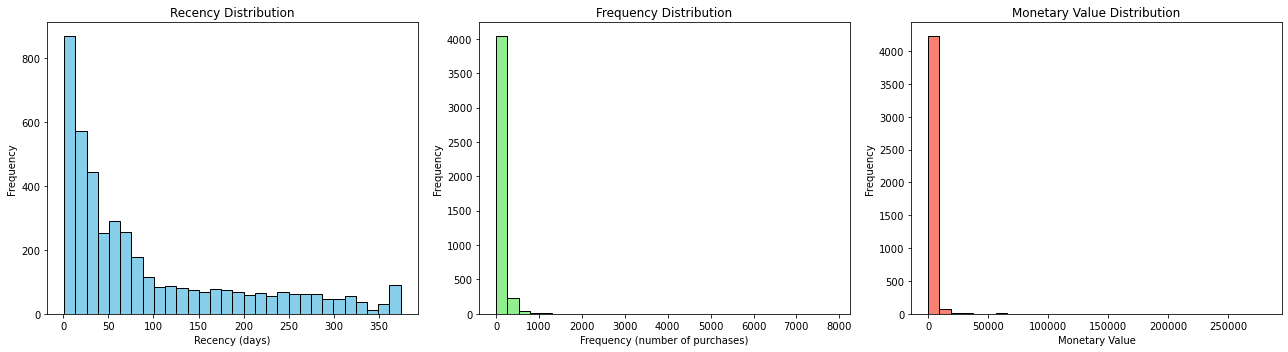

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Histogram for Recency
axes[0].hist(datamart['Recency'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Frequency')

# Histogram for Frequency
axes[1].hist(datamart['Frequency'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Frequency (number of purchases)')
axes[1].set_ylabel('Frequency')

# Histogram for MonetaryValue
axes[2].hist(datamart['MonetaryValue'], bins=30, color='salmon', edgecolor='black')
axes[2].set_title('Monetary Value Distribution')
axes[2].set_xlabel('Monetary Value')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Observation:**

All three histograms show that the majority of the dataset is concentrated in the lower end of the scales, with a few outliers stretching to the higher ends. This is consistent with typical customer behavior patterns, where a small portion of the customer base contributes most to the frequency and monetary value.


# Machine Learning

### Removing outliers

In [102]:
Q1 = datamart.quantile(0.25)
Q3 = datamart.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (datamart < lower_bound) | (datamart > upper_bound)

datamart = datamart[~outliers.any(axis=1)]

### Scaling Dataset

Since we will be using K-Means to define customer segmentation, we will have to scale our data. If one feature has a broad range of values, the distance will be dominated by this particular feature, leading to biased results. Scaling ensures that each feature contributes approximately proportionately to the final distance.

In [103]:
df_scaled = datamart.copy(deep=True)
df_scaled

,Recency,Frequency,MonetaryValue
0,2,12,196.89
2,32,50,1257.51
3,23,77,1244.59
4,20,29,582.60
5,226,14,259.45
...,...,...,...
4329,139,30,501.14
4331,6,10,635.68
4332,191,30,455.25
4333,234,20,149.58


In [104]:
cols_to_scale = ['Recency', 'Frequency', 'MonetaryValue']
scaler = StandardScaler()

df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled)
df_scaled.describe()

,Recency,Frequency,MonetaryValue
count,3.606000e+03,3.606000e+03,3.606000e+03
mean,4.738306e-17,1.305420e-17,-1.628081e-16
std,1.000139e+00,1.000139e+00,1.000139e+00
min,-1.023024e+00,-1.059870e+00,-1.077892e+00
25%,-7.768820e-01,-7.441226e-01,-7.167734e-01
50%,-3.852918e-01,-3.652257e-01,-3.431328e-01
75%,5.769014e-01,4.767676e-01,3.933589e-01
max,2.624359e+00,3.613192e+00,3.604157e+00


### Performing KMeans

### Elbow Method (SSE)

The elbow method is a visual approach used to determine the best value of K in k-means clustering. The point where the plot bends or makes an 'elbow' signifies the optimal K value (number of clusters), indicating that increasing the number of clusters beyond this point does not significantly improve the variance explained by the clustering and can lead to overfitting.


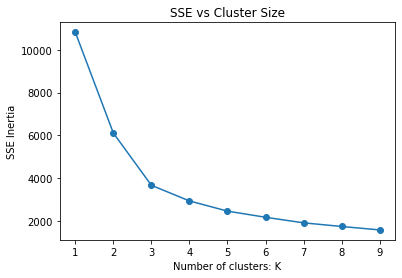

In [105]:
inertia_scores = []
for K in range(1, 10):
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)
    kmeans.fit(df_scaled)
    inertia_scores.append(kmeans.inertia_)
    
plt.plot(range(1,10),inertia_scores,marker='o')
plt.title("SSE vs Cluster Size")
plt.xlabel("Number of clusters: K")
plt.ylabel("SSE Inertia")
plt.show()

As the graph shows, the optimal number of clusters is 3

### Silhouette Score

A silhouette score is a measure used to evaluate the quality of clusters created by a clustering algorithm, such as K-means. It gives an indication of how well each object lies within its cluster, which is a reflection of the cluster's compactness and separation from other clusters. The silhouette score has a range from -1 to 1, where:

A score close to +1 indicates that the data point is well inside its own cluster and far away from other clusters.
A score of 0 indicates that the data point is on or very close to the decision boundary between two neighboring clusters.
A score close to -1 suggests that the data point might have been assigned to the wrong cluster.

Ultimately the decision of clusters depends on how the business wants to define the clusters.

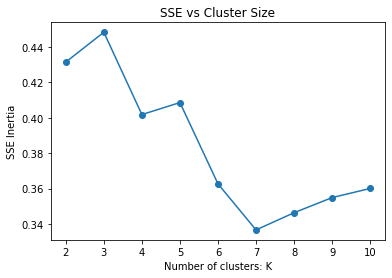

In [106]:
silhouette_scores = []
for K in range(2, 11):
    model = KMeans(n_clusters=K, random_state=0, n_init=10)
    cluster_assignments = model.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_assignments)
    silhouette_scores.append(silhouette_avg)
    
plt.plot(range(2,11),silhouette_scores,marker='o')
plt.title("SSE vs Cluster Size")
plt.xlabel("Number of clusters: K")
plt.ylabel("SSE Inertia")
plt.show()

### KMeans

In [111]:
scaled_cols = ['Recency_Scaled','Frequency_Scaled','MonetaryValue_Scaled']
model = KMeans(n_clusters = 3, random_state = 0,n_init=10)
model.fit(df_scaled)
datamart['Cluster'] = model.predict(df_scaled)
datamart.head()

,Recency,Frequency,MonetaryValue,Cluster
0,2,12,196.89,0
2,32,50,1257.51,0
3,23,77,1244.59,0
4,20,29,582.60,0
5,226,14,259.45,1


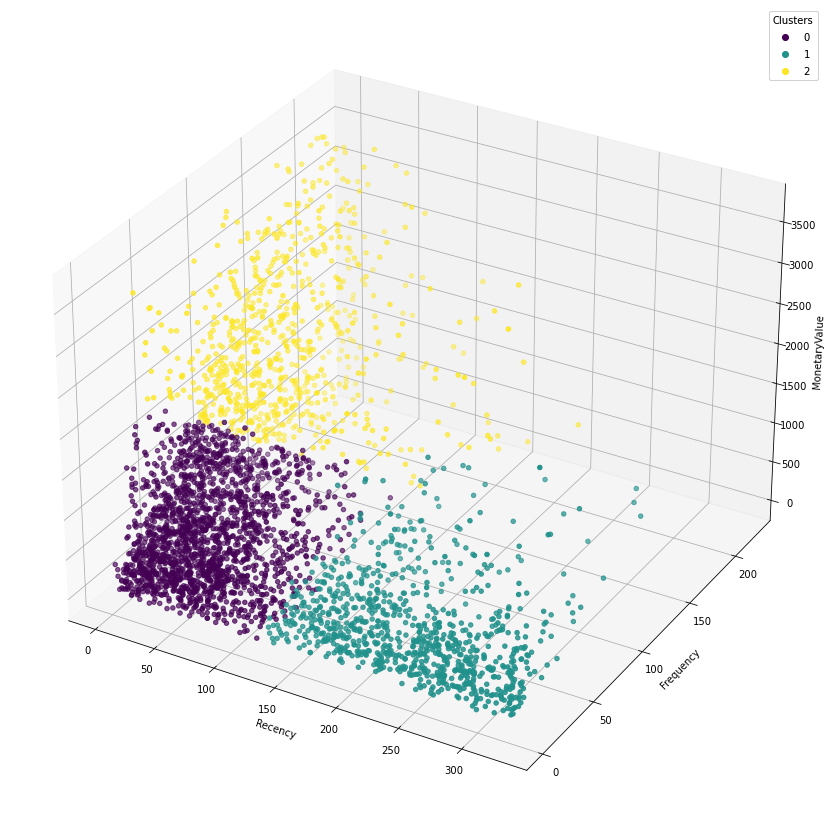

In [108]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(50, 15))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(datamart['Recency'], datamart['Frequency'], datamart['MonetaryValue'], c=datamart['Cluster'], cmap='viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

legend = ax.legend(*scatter.legend_elements(), loc='upper right', title='Clusters')
ax.add_artist(legend)

plt.show()


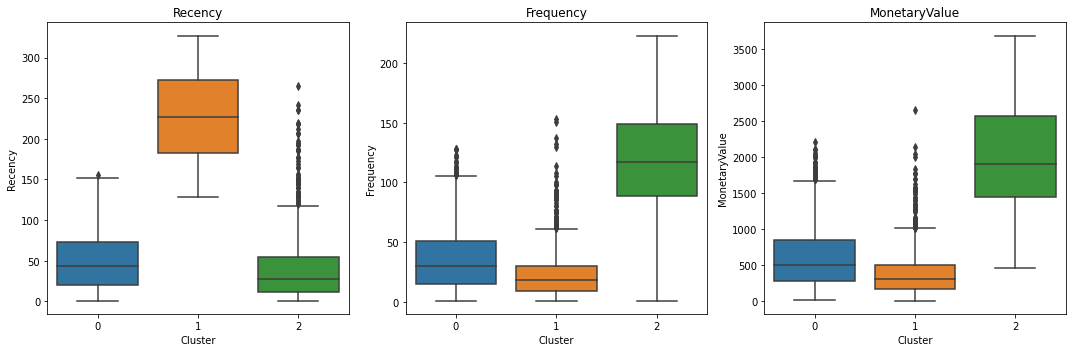

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#Boxplot for Recency
sns.boxplot(x ='Cluster', y='Recency', data=datamart, ax=axs[0])
axs[0].set_title('Recency')

#Boxplot for Frequency
sns.boxplot(x ='Cluster',y='Frequency', data=datamart, ax=axs[1])
axs[1].set_title('Frequency')


#Boxplot for MonetaryValue
sns.boxplot(x ='Cluster',y='MonetaryValue', data=datamart, ax=axs[2])
axs[2].set_title('MonetaryValue')


plt.tight_layout()
plt.show()

In [110]:
df2 = datamart.groupby(['Cluster']).agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean','count'],
}).round(0)
df2

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          50.0      35.0         600.0  1919
1         229.0      24.0         395.0   899
2          41.0     121.0        1990.0   788

| Cluster | Customer Type       | RFM Characteristics                                                                                   | Action                                                                                                    |
|---------|---------------------|------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| 0       | Occasional Engagers | This group shows moderate purchasing frequency but hasn't engaged recently and spends relatively less. They might be occasional or seasonal shoppers. | Focus on re-engagement and regular communication to encourage more frequent purchases.                   |
| 1       | Loyal High Spenders | Customers in this cluster are highly engaged, making frequent purchases, spending significantly, and doing so very recently. They are likely to be loyal and highly valuable customers. | Prioritize retention and personalized experiences. Exclusive offers and loyalty rewards could be effective. |
| 2       | Consistent Customers| These customers are moderately recent, frequent, and spend a decent amount. They represent regular and consistent shoppers.                                      | Implement tactics to increase their purchase frequency and value, like upselling, cross-selling, and personalized recommendations.                              |
